# Accessing DC2 truth and simulated observations data in PostgreSQL at NERSC

Owner: **Joanne Bogart [@jrbogart](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jrbogart)**  
Last Verified to Run: **2020-11-24**

This notebook demonstrates access to truth catalog data via the PostgreSQL database at NERSC.  Currently (May 1, 2020) two kinds of truth catalogs are available: star truth and supernova truth.  This notebook will concentrate on star truth. The minion observation database is also available, as well as the Run2.2i dr6 object catalog (dpdd columns approximating specification in LSE-163 only).

__Learning objectives__:

After going through this notebook, you should be able to:
  1. Find out what star truth and simulated observation information is available and query it.
  4. Make use of standard tools to, e.g., plot light curves

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter.nersc.gov. To setup your NERSC environment, please follow the instructions available here: 
https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC
### Prerequisites
* See [Getting Started with PostgreSQL at NERSC](https://confluence.slac.stanford.edu/x/s4joE), especially the "Preliminaries" section
* Some minimal acquaintance with SQL is helpful. See the "SQL Primer" section of the above document

### Conventions
* SQL keywords have been written in ALL CAPS only to make them stand out in queries. (The database server ignores case in queries for keywords, column names and table names.)
  

In [49]:
import psycopg2
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd

Make the db connection

In [50]:
dbname = 'desc_dc2_drp'
dbuser = 'desc_dc2_drp_user'
dbhost = 'nerscdb03.nersc.gov'
dbconfig = {'dbname' : dbname, 'user' : dbuser, 'host' : dbhost}
dbconn = psycopg2.connect(**dbconfig)

In [51]:
obs_schema = 'minion_test'
truth_schema = 'star_truth'
object_schema = 'run22i_dr6_wfd_v1'
#truth_schema = 'sne_truth'

Initial steps in this notebook can be run for supernova truth instead of star truth
just by changing the value for `truth_schema` above, but the section labeled **Sample Query** 
and the light curve queries need more adjustments.

Convenience utilities, defined here so as not to clutter
up the main line.

In [52]:
def get_schema_tables(conn, schema):
    '''
    Returns 1-d numpy array of table names
    '''
    q = f"""SELECT DISTINCT table_name FROM information_schema.columns 
         WHERE table_schema='{schema}' 
         ORDER BY table_name"""
    with conn.cursor() as cursor:
        cursor.execute(q)
        records = cursor.fetchall()
    tables = np.array([r[0] for r in records])
    return tables

In [53]:
def get_table_columns(conn, schema, table):
    '''
    Returns a pandas dataframe with columns column_name, datatype
    '''
    q = f"""SELECT column_name, data_type FROM information_schema.columns 
        WHERE table_schema='{schema}' AND table_name='{table}' 
        ORDER BY column_name"""
    with conn.cursor() as cursor:
        cursor.execute(q)
        records = cursor.fetchall()
    print(len(records))
    df = pd.DataFrame(records, columns=['column_name', 'data_type'])
    return df
    

Another convenience routine.
It makes use of the public function `conesearch` and provides a place to document its arguments.
See also a [more comprehensive list](https://github.com/LSSTDESC/DC2-PostgreSQL/blob/master/postgres-objcatalog/README_functions.md) of such functions.

In [54]:
def format_cone_search(coord_column, ra, dec, radius):
    '''
    Parameters
    coord_column:  name of column of type earth in the table
    ra:  ra value at center of cone (degrees)
    dec:  dec value at center of cone (degrees)
    radius: radius of cone (arcseconds)
    
    Returns
    Condition to be inserted into WHERE clause for the query
    '''
    cond = f"""conesearch({coord_column},'{ra}','{dec}','{radius}')"""
    return cond

Display all tables belonging to the schema. 

In [55]:
schemas = [truth_schema, obs_schema]
for s in schemas:
    tables = get_schema_tables(dbconn, s)
    print(f"\nTables for schema {s}:")
    for t in tables: 
        print(t)


Tables for schema star_truth:
stellar_variability_stats
stellar_variability_truth
truth_summary

Tables for schema minion_test:
cloud
config
config_file
field
log
missedhistory
obshistory
obshistory_proposal
proposal
proposal_field
seeing
seqhistory
seqhistory_missedhistory
seqhistory_obshistory
session
slewactivities
slewhistory
slewmaxspeeds
slewstate
summary
timehistory


Display all columns belonging to a couple tables

In [56]:
truth_summary_info = get_table_columns(dbconn, truth_schema, 'truth_summary' )
truth_summary_info.style.set_properties(**{'text-align': 'left'})
truth_summary_info

20


,column_name,data_type
0,coord,USER-DEFINED
1,dec,double precision
2,flux_g,real
3,flux_g_nomw,real
4,flux_i,real
5,flux_i_nomw,real
6,flux_r,real
7,flux_r_nomw,real
8,flux_u,real
9,flux_u_nomw,real


In [57]:
stellar_variability_info = get_table_columns(dbconn, truth_schema, 'stellar_variability_truth' )
stellar_variability_info.style.set_properties(**{'text-align': 'left'})
stellar_variability_info

5


,column_name,data_type
0,bandpass,text
1,delta_flux,double precision
2,id,text
3,mjd,double precision
4,obshistid,integer


The most generally useful table in the obs database is `summary`.  Note ra and dec are stored in radians in this table.

In [58]:
obs_summary_info = get_table_columns(dbconn, obs_schema, 'summary' )
obs_summary_info.style.set_properties(subset=["column_name", "data_type"], **{'text-align': 'right'})
obs_summary_info

54


,column_name,data_type
0,airmass,real
1,altitude,double precision
2,azimuth,double precision
3,darkbright,real
4,descditheredcoord,USER-DEFINED
5,descdithereddec,double precision
6,descditheredra,double precision
7,descditheredrottelpos,double precision
8,dist2moon,double precision
9,ditheredcoord,USER-DEFINED


### Sample Query
Find delta flux readings for stars which are expected to be in the field of view for a particular visit. This sort of query returns practically instantly. In the `stellar_variability_truth` both of the columns mentioned in the `WHERE` clause - `id` and `obshistid` - are indexed.

In [59]:
obshistid = 731791
table = 'stellar_variability_truth'
ids = ["'835183'", "'31303590103'","'31102013522'","'31303588649'", "'30317268917'",
       "'30825472052'","'835279'","'31102039372'","'30825477672'","'31102046245'", 
       "'30321363109'","'31102051190'","'31102061342'","'30321363877'","'31102061079'",
       "'31411663457'", "'31107813412'"]
id_list = ",".join(ids)

flux_q = f"""SELECT id, delta_flux FROM {truth_schema}.{table} 
         WHERE (obshistid={obshistid})
         AND id IN ({id_list});"""
print(flux_q)
with dbconn.cursor() as cursor:
    cursor.execute(flux_q)
    f_records = cursor.fetchall()
df_flux = pd.DataFrame(f_records, columns=['id', 'delta_flux']) 
df_flux

SELECT id, delta_flux FROM star_truth.stellar_variability_truth 
         WHERE (obshistid=731791)
         AND id IN ('835183','31303590103','31102013522','31303588649','30317268917','30825472052','835279','31102039372','30825477672','31102046245','30321363109','31102051190','31102061342','30321363877','31102061079','31411663457','31107813412');


,id,delta_flux
0,30825477672,-30241.496100
1,31102061079,-24522.487526
2,31102039372,-2895.587106
3,31303590103,11601.473802
4,31102013522,47050.033179
5,31107813412,-21383.346704
6,31102061342,-10998.545541
7,30321363109,39996.367988
8,31102051190,-34863.941218
9,30317268917,81.519569


### Area searches

The column `coord` in table `truth_summary` and columns with "coord" in their names in the observation summary table are of a special type `earth`.  The value is a triple of double precision numbers describing the position on a unit sphere corresponding to `ra` and `dec`. Indexes have been defined on these columns to speed up area searches.

The observation with obshistid=14 has desc dithered ra, dec = (1.69831745204, -0.59856) *in radians*. Find all observations within a radius (expressed in arcseconds). 

**Warning:** All ra, dec in the observation summary table are in radians. ra and dec in `truth_summary` are in degrees. `format_cone_search` needs ra, dec in degrees.

In [60]:
radius = 500
ra_deg = np.degrees((1.69831745204,))[0]
dec_deg = np.degrees((-0.59856,))[0]
dec = -0.59856
cond = format_cone_search('descditheredcoord', ra_deg, dec_deg, radius)
obs_query = f"""SELECT obshistid,descditheredra,descdithereddec FROM {obs_schema}.summary
            WHERE {cond}"""
# Uncomment the following to confirm that the query looks reasonable
#print(obs_query)
with dbconn.cursor() as cursor:
    %time cursor.execute(obs_query)
    records = cursor.fetchall()
    df_obs = pd.DataFrame(records, columns=['obshistid', 'ra_radians', 'dec_radians'])
df_obs

CPU times: user 0 ns, sys: 1.6 ms, total: 1.6 ms
Wall time: 1.82 s


,obshistid,ra_radians,dec_radians
0,14,1.698317,-0.598560
1,276199,1.699637,-0.599557
2,502253,1.695834,-0.599596
3,568455,1.697556,-0.596829


### Light curves
Find length of light curves for variable stars near a particular location

In [61]:
# pick a location that probably gets lots of visits
# for (70.0, -30.0, 80)  get 3; for (60.0, -30.0, 80) get 1
ra = 60.0       # 70.0     
dec = -30.0
radius = 150    
tbl_spec = f"""SELECT S.id, S.ra, S.dec, max(abs(V.delta_flux)),count(V.bandpass) AS visit_count 
           FROM {truth_schema}.truth_summary AS S JOIN 
           {truth_schema}.stellar_variability_truth AS V ON S.id=V.id """
where = "WHERE " + format_cone_search('S.coord', ra, dec, radius) + " AND S.is_variable=1 "
group_by = " GROUP BY S.id,S.ra,S.dec"
q = tbl_spec + where + group_by

# This takes a couple minutes to complete
with dbconn.cursor() as cursor:
    %time cursor.execute(q)
    records = cursor.fetchall()


CPU times: user 4.98 ms, sys: 1.9 ms, total: 6.88 ms
Wall time: 2min 6s


In [62]:
df_lengths = pd.DataFrame(records, columns=['id', 'ra','dec', 'max_delta_flux','count'])
df_lengths

,id,ra,dec,max_delta_flux,count
0,1568926871,59.977133,-29.969161,0.697337,1319
1,1568931714,60.023252,-29.989211,645.042036,1308
2,1568933311,60.016031,-29.998623,13.495022,1311
3,1664726359,59.960487,-29.980270,2.175327,1321
4,31303561602,59.983703,-30.029734,3243.389799,1316
5,31405535176,59.967237,-30.005953,47.215255,1314
6,31405535380,59.977097,-30.010716,12.596245,1315
7,31500246015,59.958175,-30.001932,1474.191936,1315
8,31500246855,60.029707,-30.021525,3.332326,1311


Similar to above, but this time don't count visits. Get the delta_flux values instead

In [63]:
ra = 70.0     
dec = -30.0
radius = 80 
columns = ['S.id', 'ra', 'dec', 'bandpass', 'delta_flux']
col_list = (',').join(columns)
tbl_spec = f"""SELECT {col_list} 
           FROM {truth_schema}.truth_summary AS S JOIN 
           {truth_schema}.stellar_variability_truth AS V ON S.id=V.id """
where = "WHERE " + format_cone_search('S.coord', ra, dec, radius) + " and S.is_variable=1 "
q = tbl_spec + where

with dbconn.cursor() as cursor:
    %time cursor.execute(q)
    records_lc = cursor.fetchall()

CPU times: user 0 ns, sys: 8.1 ms, total: 8.1 ms
Wall time: 2min 4s


In [64]:
df_cone_lcs = pd.DataFrame(records_lc, columns=columns)
df_cone_lcs

,S.id,ra,dec,bandpass,delta_flux
0,1569165932,69.988410,-29.982076,u,0.269632
1,1569165932,69.988410,-29.982076,y,-16.353754
2,1569165932,69.988410,-29.982076,i,-9.540451
3,1569165932,69.988410,-29.982076,i,-7.269259
4,1569165932,69.988410,-29.982076,y,6.594410
...,...,...,...,...,...
4096,31405616373,70.007307,-30.017778,g,1.443977
4097,31405616373,70.007307,-30.017778,g,1.101347
4098,31405616373,70.007307,-30.017778,r,0.615432
4099,31405616373,70.007307,-30.017778,r,0.511739


### Plot light curves for one star
Pick the second object from the results of the first query in this section (id=1568931714) since max_delta_flux is large
#### Get the data
Get delta_flux and time values for the plot and some summary information about the star. Use `ORDER BY` clause so that data are presented conveniently for plotting.

In [65]:
id = 1568931714
var_tbl = 'stellar_variability_truth'
lc_q = f"""SELECT bandpass,mjd,delta_flux FROM {truth_schema}.{var_tbl}
       WHERE id='{id}' ORDER BY bandpass, mjd;"""
print(lc_q)
with dbconn.cursor() as cursor:
    %time cursor.execute(lc_q)
    lc_records = cursor.fetchall()
print(len(lc_records))
df_single_lc = pd.DataFrame(lc_records, columns=['bandpass','mjd','delta_flux'])
df_single_lc


SELECT bandpass,mjd,delta_flux FROM star_truth.stellar_variability_truth
       WHERE id='1568931714' ORDER BY bandpass, mjd;
CPU times: user 1.58 ms, sys: 801 µs, total: 2.38 ms
Wall time: 11.1 ms
1308


,bandpass,mjd,delta_flux
0,g,59791.353361,-76.243969
1,g,59791.373095,-76.405375
2,g,59791.402524,-76.621326
3,g,59823.327159,-74.982182
4,g,59823.345302,-76.315057
...,...,...,...
1303,z,63170.306288,-58.205418
1304,z,63198.209002,230.267438
1305,z,63198.222740,227.029392
1306,z,63198.223188,226.923061


In [66]:
sum_tbl = 'truth_summary'
sum_fluxes = ','.join([f"flux_{b}" for b in ['g', 'i', 'r', 'u', 'y', 'z']])
sum_q = f"""SELECT ra,dec,{sum_fluxes} FROM {truth_schema}.{sum_tbl} 
         WHERE id='{id}';"""
print(sum_q)
with dbconn.cursor() as cursor:
    %time cursor.execute(sum_q)
    sum_record = cursor.fetchone()
lc_ra = sum_record[0]
lc_dec = sum_record[1]
print(f'ra={lc_ra}, dec={lc_dec}')

SELECT ra,dec,flux_g,flux_i,flux_r,flux_u,flux_y,flux_z FROM star_truth.truth_summary 
         WHERE id='1568931714';
CPU times: user 948 µs, sys: 0 ns, total: 948 µs
Wall time: 877 µs
ra=60.0232525, dec=-29.989211


#### Plotting

In [67]:
from astropy.time import Time
def plot_band_lc(axes, times, fluxes, params):
    out = axes.scatter(np.asarray(times), np.asarray(fluxes), **params)

In [68]:
def plot_level(axes, yvalue, params):
    xmin, xmax = axes.get_xlim()
    out = axes.plot(np.asarray([xmin, xmax]), np.asarray([yvalue, yvalue]), **params)

In [69]:
def format_title(id, ra, dec, band=None):  
    if band is None:
        return f'Per-band light curves for star {id} at (ra,dec)=({ra}, {dec})'
    else:
        return f'Light curve for star {id}, band={band} at (ra,dec)=({ra}, {dec})'

In [70]:
def plot_object(title, the_data, band=None):
    '''
    Plot r, g and i light 'curves' (delta_flux as scatter plot) for an object
    or plot only requested band
    Parameters
    -----------
    title : string
    the_data : data frame which must include columns filtername, obsstart, mag
    '''
    good_d = the_data[(np.isnan(the_data.delta_flux)==False)]
    red_d = good_d[(good_d.bandpass=="r")]
    green_d = good_d[(good_d.bandpass=="g")]
    i_d = good_d[(good_d.bandpass=="i")]
    #print("red data shape: ", red_e.shape, "   green data shape: ", green_e.shape, "  i data shape: ", i_e.shape)
    fix, axes = plt.subplots(figsize=(12,8))

    plt.title(title)
    plt.xlabel('Julian date')
    plt.ylabel('Delta flux')

    params_r = {'marker' : 'o', 'label' : 'r band', 'color' : 'red'}
    params_g = {'marker' : 'o', 'label' : 'g band', 'color' : 'green'}
    params_i = {'marker' : 'o', 'label' : 'i band', 'color' : 'orange'}
    #print('In plot_object printing i-band values')
    #for ival in list(i_d['mag']): print(ival)
    if band is None or band=='r':
        plot_band_lc(axes, list(red_d['mjd']), list(red_d['delta_flux']), params_r)
    if band is None or band=='g':
        plot_band_lc(axes, list(green_d['mjd']), list(green_d['delta_flux']), params_g)
    if band is None or band=='i':
        plot_band_lc(axes, list(i_d['mjd']), list(i_d['delta_flux']), params_i)
    #plot_level(axes, coadd_mag['r'], {'label' : 'r coadd mag', 'color' : 'red'})
    #plot_level(axes, coadd_mag['g'], {'label' : 'g coadd mag', 'color' : 'green'})
    #plot_level(axes, coadd_mag['i'], {'label' : 'i coadd mag', 'color' : 'orange'})
    if band is None:
        plt.legend()

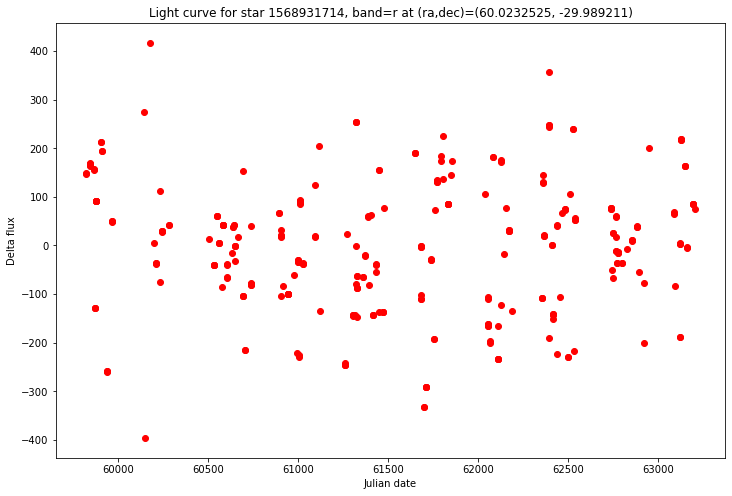

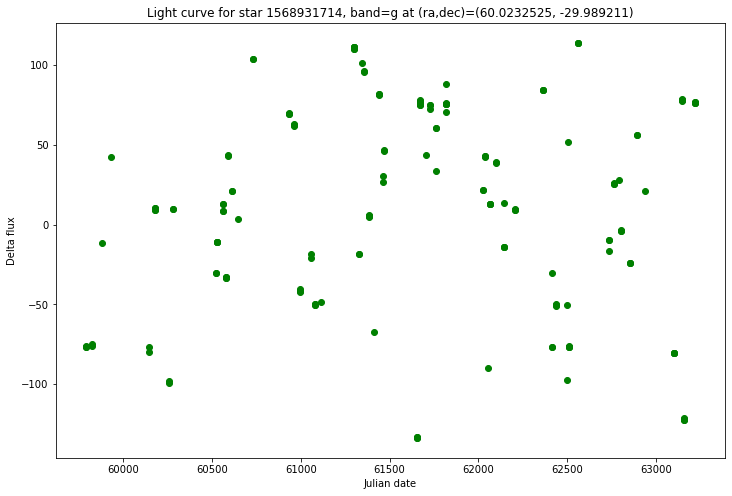

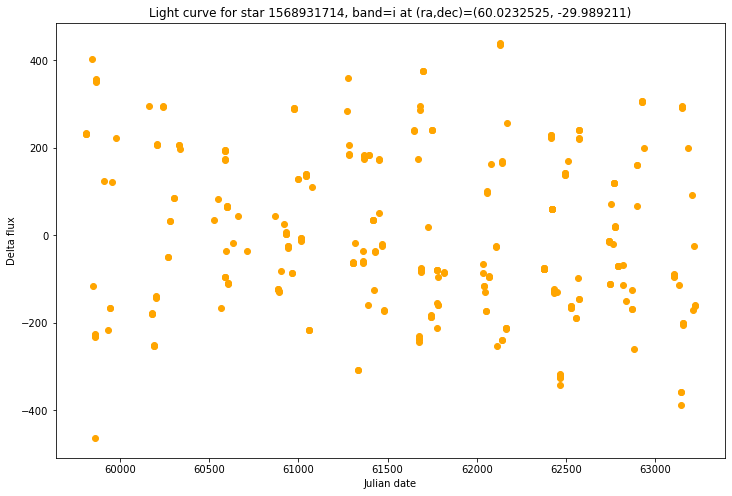

In [71]:
for band in ('r','g','i'):
    title = format_title(id, lc_ra, lc_dec, band)
    plot_object(title, df_single_lc, band)

#### Is it in the object table?
First get truth information for our chosen star, then try to find a match, restricting to point sources within a few arcseconds

In [72]:
truth_q = f"SELECT ra,dec,flux_g,flux_r,flux_i from {truth_schema}.truth_summary where id='{id}'"
print(truth_q)
with dbconn.cursor() as cursor:
    %time cursor.execute(truth_q)
    truth_records = cursor.fetchall()
#truth_records
print(len(truth_records))
truth_df = None
truth_df = pd.DataFrame(truth_records, columns=['ra', 'dec', 'flux_g', 'flux_r', 'flux_i'])
truth_df.shape
truth_df

SELECT ra,dec,flux_g,flux_r,flux_i from star_truth.truth_summary where id='1568931714'
CPU times: user 734 µs, sys: 323 µs, total: 1.06 ms
Wall time: 707 µs
1


,ra,dec,flux_g,flux_r,flux_i
0,60.023252,-29.989211,35645.6,83204.1,118299.0


In [73]:
cols = ['objectid','ra', 'dec', 'psflux_g','psflux_r', 'psflux_i']
col_spec = ','.join(cols)
obj_q = f"""SELECT {col_spec} from {object_schema}.dpdd_object  WHERE extendedness < 0.5 AND """
radius = 20   # in arcseconds
obj_q += format_cone_search('coord', lc_ra, lc_dec, radius) 
print(obj_q)
with dbconn.cursor() as cursor:
    %time cursor.execute(obj_q)
    obj_records = cursor.fetchall()
obj_df = pd.DataFrame(obj_records, columns=cols)
obj_df

SELECT objectid,ra,dec,psflux_g,psflux_r,psflux_i from run22i_dr6_wfd_v1.dpdd_object  WHERE extendedness < 0.5 AND conesearch(coord,'60.0232525','-29.989211','20')
CPU times: user 0 ns, sys: 1.28 ms, total: 1.28 ms
Wall time: 5.84 ms


,objectid,ra,dec,psflux_g,psflux_r,psflux_i
0,20411630210785469,60.019651,-29.987849,46.06080,138.6000,247.1130
1,20411630210785502,60.023462,-29.987267,-6.95959,31.2781,141.1960
2,20411630210819802,60.025504,-29.993284,81.57740,113.7590,179.8790
3,20411630210820156,60.023252,-29.989211,35625.80000,83112.2000,118024.0000
4,20411630210820162,60.025075,-29.988941,32.82040,87.9223,103.8980
5,20411630210820211,60.017784,-29.989968,67.94240,96.9730,198.9990
6,20411630210820388,60.029270,-29.988191,43.12250,81.3510,97.3848
